In [1]:
import time
# import IPython
import os
import json
from datetime import datetime
import pyswarm
import pandas

import joblib
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow import keras
import tensorflow.keras.backend as K
from pyswarm import pso


from keras.models import Sequential, Model
# from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Lambda, Layer
# from tensorflow.keras import losses
# from keras.utils.vis_utils import plot_model, model_to_dot

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.preprocessing

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error

K.set_floatx('float32')

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

tf.enable_v2_behavior()

from tester.tester import Tester
import random

2022-02-23 12:54:22.922296: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-23 12:54:22.922330: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
lb = [2.2, 1.08, -40.]  # lower bounds of the design variables, i.e. input params for the sut_model
ub = [2.8, 1.41, 175.] 
# log_path = os.path.join('.','2022_02_02_11_45_57')
# log_path

In [3]:
with open('./validation_samples.csv', newline='') as csvfile:
    reader = pandas.read_csv(csvfile,delimiter=';')

nom_cols =(reader['corner']=='nom') & (reader['Parameter Label']=='V_ref_1v133_untrimmed')
validation_frame= reader[nom_cols]
valid_real_ys=[]
valid_real_Xs=[]
for index, row in validation_frame.iterrows():
    valid_real_ys.append(row['Value'])
    valid_real_Xs.append([row['p_vdda_evr'], row['p_vddpd'], row['temperature']])

    
print(len(valid_real_Xs))
print(len(valid_real_ys))


972
972


In [4]:
# Deterministic training

# path = os.path.join('.', 'Predictions','training_points64.npyz')
# with open(path, 'rb') as file:
#     data = np.load(file)
#     training_Xs=data['points']
    
# path = os.path.join('.', 'Predictions','training_values64.npyz')
# with open(path, 'rb') as file:
#     data = np.load(file)
#     training_ys=data['values']

# indices=[i for i in range (len(valid_real_Xs))]
# validation_ids=indices

# val_Xs=np.array([valid_real_Xs[i] for i in validation_ids])
# val_ys=np.array([valid_real_ys[i] for i in validation_ids])

In [5]:
# Random training

indices=[i for i in range (len(valid_real_Xs))]
training_ids=random.sample(indices,27)
validation_ids=indices
for val in training_ids:
    validation_ids.remove(val)

training_Xs=np.array([valid_real_Xs[i] for i in training_ids])
training_ys=np.array([valid_real_ys[i] for i in training_ids])

val_Xs=np.array([valid_real_Xs[i] for i in validation_ids])
val_ys=np.array([valid_real_ys[i] for i in validation_ids])

In [6]:
# Normalize the data
transform_X = StandardScaler()
norm_training_Xs = transform_X.fit_transform(training_Xs)
norm_training_Xs = np.array(norm_training_Xs, dtype=np.float32)

norm_val_Xs = transform_X.fit_transform(val_Xs)
norm_val_Xs = np.array(norm_val_Xs, dtype=np.float32)


transform_y = StandardScaler()
norm_training_ys = transform_y.fit_transform(training_ys[..., np.newaxis]).ravel()
norm_training_ys = np.array(norm_training_ys, dtype=np.float32)

norm_val_ys = transform_y.fit_transform(val_ys[..., np.newaxis]).ravel()
norm_val_ys = np.array(norm_val_ys, dtype=np.float32)


2022-02-23 12:54:27.118200: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-23 12:54:27.118248: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-23 12:54:27.118273: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (t460slalb): /proc/driver/nvidia/version does not exist
2022-02-23 12:54:27.118687: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-23 12:54:27.401070: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, bu

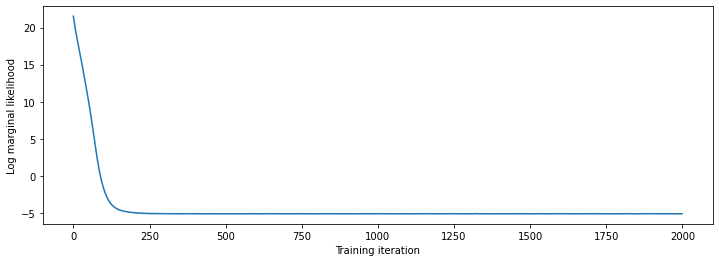

In [7]:
# Define trainable variables
# We will use the squared exponential kernel with different relevances for each direction. We also consider some variance due to noise. 

constrain_positive = tfb.Shift(np.finfo(np.float32).tiny)(tfb.Exp())
amplitude = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='amplitude',
    dtype=np.float32)

relevances = tfp.util.TransformedVariable(
    initial_value=np.ones(3),
    bijector=constrain_positive,
    name='relevances',
    dtype=np.float32)

# noise_var = tfp.util.TransformedVariable(
#     initial_value=0.01,
#     bijector=constrain_positive,
#     name='noise_variance',
#     dtype=np.float32)
noise_var = tf.constant(0.)

# trainable_variables=[v.trainable_variables[0] for v in [amplitude, relevances, noise_var]]

trainable_variables = [v.trainable_variables[0] for v in [amplitude, relevances]]

# We define a Gaussian proccess with the chosen kernel that depends on our trainable variables

kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale=1.0)
kernel = tfk.FeatureScaled(kernel, scale_diag=relevances)
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=norm_training_Xs,
    observation_noise_variance=noise_var,
    jitter=1e-5)


# Define a tf.function for faster repeated evaluation 
@tf.function(autograph=False, experimental_compile=False)
def log_likelihood():
    return gp.log_prob(norm_training_ys)


# Now we optimize the model parameters.
num_iters = 2000
optimizer = tf.optimizers.Adam(learning_rate=.01)

# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float32)
for i in range(num_iters):
    with tf.GradientTape() as tape:
        loss = -log_likelihood()
        grads = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(grads, trainable_variables))
        lls_[i] = loss.numpy()

# Plot the loss evolution as a sanity check
plt.figure(figsize=(12, 4))
plt.plot(lls_)
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")
# path = os.path.join(log_path, 'loss.png')
plt.show()

In [8]:
gp_model = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=norm_val_Xs,
    observation_index_points=norm_training_Xs,
    observations=norm_training_ys,
    observation_noise_variance=noise_var,
    predictive_noise_variance=0.,
    jitter=1e-4)
pred_norm_ys = gp_model.mean().numpy()
pred_real_ys = transform_y.inverse_transform(pred_norm_ys.reshape(-1,1)).flatten()

valid_errs = pred_real_ys - val_ys
print("Maximum error= {}".format(np.amax(valid_errs)))
print("RSME = {}".format(np.sqrt(np.mean(np.square(valid_errs)))))


Maximum error= 0.00025607836029051256
RSME = 9.641660086348942e-05


In [9]:
# intervals=[ [lb[i], ub[i]] for i in range(3)]
# intervals

# partitions=[]

# number=4


# for i in range(3):
#     interval=intervals[i]
#     length=interval[1]-interval[0]
#     step= length/(number+2)
#     partition=[ (interval[0]+ (j+1)*step) for j in range(number)]
#     partitions.append(partition)
    
# training_points=[]



# for a in partitions[0]:
#     for b in partitions[1]:
#         for c in partitions[2]:
#             training_points.append([a,b,c])


    
# print(len(training_points))

# filepath = os.path.join('.', 'training_points64.npyz')
# to_save = {
#     'points': training_points,
# }

# with open(filepath, 'wb') as file:
#     np.savez(file, **to_save)
    
